# Figs/Movie of SST/Surface Velocities/TCC

In [2]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [30]:
#link = "gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr-v2"
#link1 = "gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr"
ex_link = "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2"

era5 = xr.open_zarr(ex_link, chunks={'time': 48},consolidated=True,)
#era = xr.open_zarr(link1, chunks={'time': 48},consolidated=True,)

In [28]:
era5

<xarray.Dataset> Size: 534TB
Dimensions:                                           (time: 552264,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 296B 1 .....
  * time                                              (time) datetime64[ns] 4MB ...
  * longitude                                         (longitude) float32 6kB ...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential                                      (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    type_of_high_vegetation                           (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>

In [82]:
era5.land_sea_mask

<xarray.DataArray 'land_sea_mask' (latitude: 721, longitude: 1440)> Size: 4MB
dask.array<open_dataset-land_sea_mask, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Attributes:
    long_name:      Land-sea mask
    short_name:     lsm
    standard_name:  land_binary_mask
    units:          (0 - 1)

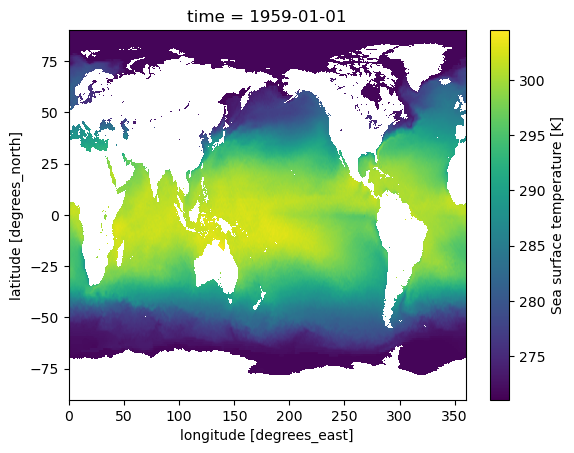

In [31]:
era5.sea_surface_temperature[0].plot()

In [65]:
#longitude = 98˚W to 81˚W
#360-98, 360-80
gom = dict(longitude=slice(262, 279), latitude=slice(31, 17.5))

In [83]:
sst = era5.sea_surface_temperature.sel(**gom) - 273.15
tcc = era5.total_cloud_cover.sel(**gom)
gp = era5.geopotential.sel(**gom)
mslp = era5.mean_sea_level_pressure.sel(**gom)
mask = era5.land_sea_mask.sel(**gom)

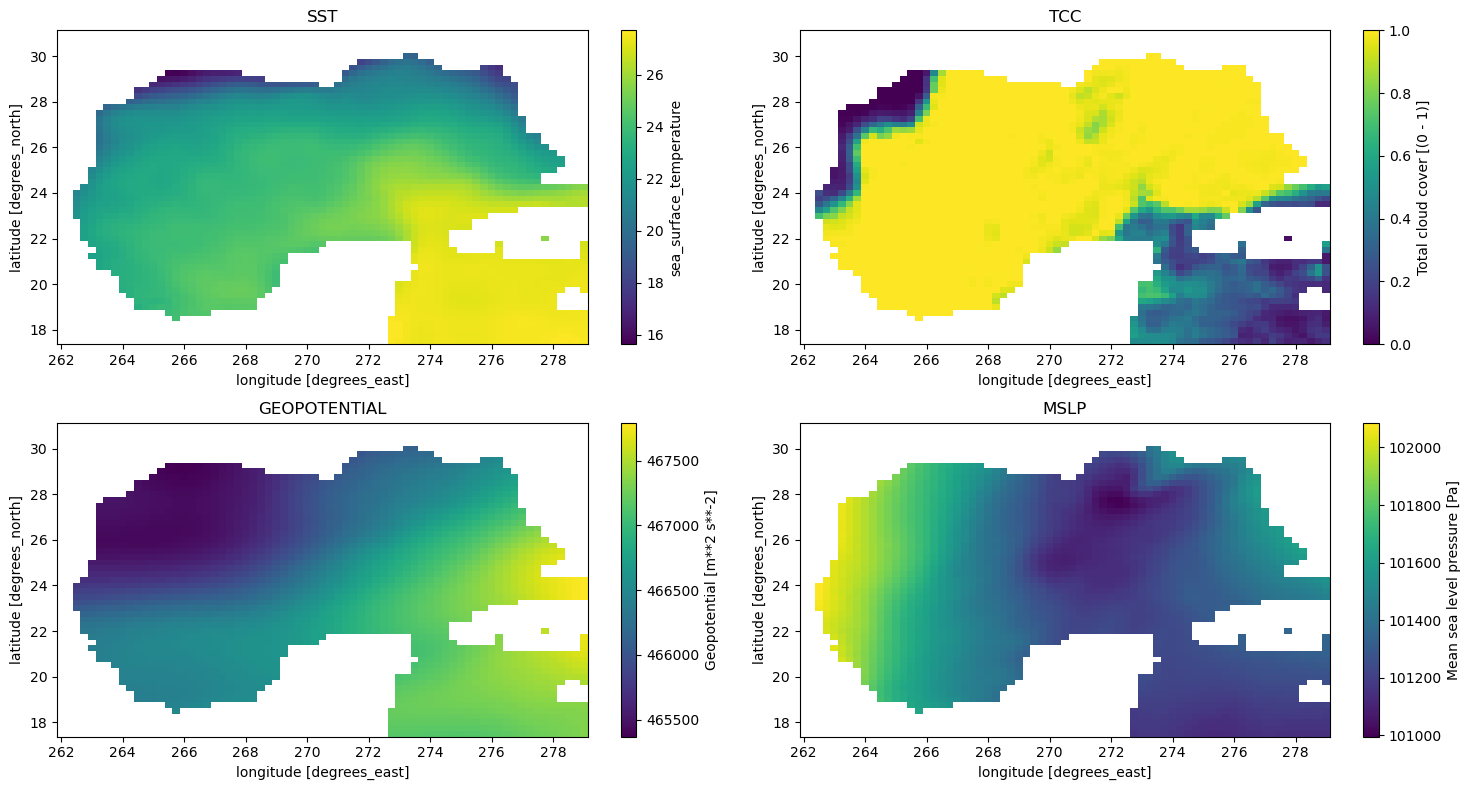

In [87]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
sst[0].where(mask==0).plot(ax=ax[0,0])
ax[0,0].set_title('SST')
tcc[0].where(mask==0).plot(ax=ax[0,1])
ax[0,1].set_title('TCC')
gp[0,0].where(mask==0).plot(ax=ax[1,0])
ax[1,0].set_title('GEOPOTENTIAL')
mslp[0].where(mask==0).plot(ax=ax[1,1])
ax[1,1].set_title('MSLP')
plt.tight_layout();